<a href="https://colab.research.google.com/github/jumafernandez/imbalanced_data/blob/main/notebooks/undersampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación de estrategias de Undersampling

__Autor:__ Juan Manuel Fernandez

__Objetivo:__ En esta notebook se prueban algunas de las estrategias más conocidas de under-sampling para el remuestreo de datasets a partir de la disminución de las instancias o muestras objetivo mayoritarias.

## Instalación y Carga de librerías y funciones útiles

### Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab

In [1]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=d7837864063203af961cf93889102af9b4db30b97b2ea1c6314f00ec2d35f7f9
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 5.1 MB/s 
     |████████████████████████████████| 199 kB 42.6 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


### Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/semi-supervisado/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/supervisado/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

Y las utilizadas para la representación de documentos.

In [4]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/supervisado/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import representacion_documentos

### Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [5]:
import warnings
from os import path
import pandas as pd
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/data/'
TRAIN_FILE = '02-01-correos-train-80.csv'
TEST_FILE = '02-02-correos-test-20.csv'

etiquetas = get_clases()

# Chequeo sobre si los archivos están en el working directory
if not(path.exists(TRAIN_FILE)):
  # Genero el enlace completo
  URL_file_train = DS_DIR + TRAIN_FILE
  URL_file_test = DS_DIR + TEST_FILE
  # Descargo los archivos
  import wget
  wget.download(URL_file_train)
  wget.download(URL_file_test)
  
# Leemos el archivo en un dataframe
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
consultas_train = list(preprocesar_correos(df_train['consulta']))
consultas_test = list(preprocesar_correos(df_test['consulta']))

print(f"\nEl conjunto de entrenamiento tiene la dimensión: {len(consultas_train)}.")
print(f"El conjunto de testeo tiene la dimensión: {len(consultas_test)}.")

y_train = list(df_train['clase'])
y_test = list(df_test['clase'])


El conjunto de entrenamiento tiene la dimensión: 800.
El conjunto de testeo tiene la dimensión: 200.


### Estrategia de representación de la consulta

A continuación se representa la consulta a partir de features.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3,4), token_pattern = '[\w\/\%]+')

X_train = vectorizer.fit_transform(consultas_train)
X_test = vectorizer.transform(consultas_test)     

# Esta función va dentro de un iterador entre las 5 estrategias   
estrategia = '3-4-NGRAM-CHARS' 
print('Estrategia de representación: {}' . format(estrategia))

Estrategia de representación: 3-4-NGRAM-CHARS


## Estrategias de Under-sampling

Se trabaja con las estrategias de under-sampling.

### RandomUnderSampler (Prototype selection)

RandomUnderSampler es una forma rápida y sencilla de equilibrar los datos seleccionando aleatoriamente un subconjunto de datos para las clases objetivo.

In [7]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)

X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)

In [8]:
import numpy as np

unique, counts = np.unique(y_resampled_rus, return_counts=True)

np.asarray((unique, counts)).T

array([['Boleto Universitario', '6'],
       ['Cambio de Carrera', '6'],
       ['Cambio de Comisión', '6'],
       ['Consulta por Equivalencias', '6'],
       ['Consulta por Legajo', '6'],
       ['Consulta sobre Título Universitario', '6'],
       ['Cursadas', '6'],
       ['Datos Personales', '6'],
       ['Exámenes', '6'],
       ['Ingreso a la Universidad', '6'],
       ['Pedido de Certificados', '6'],
       ['Problemas con la Clave', '6'],
       ['Reincorporación', '6'],
       ['Requisitos de Ingreso', '6'],
       ['Simultaneidad de Carreras', '6'],
       ['Situación Académica', '6']], dtype='<U35')

### ClusterCentroids (Prototype generation)

ClusterCentroids utiliza K-means para reducir el número de muestras. Por lo tanto, cada clase se sintetizará con los centroides del método K-means en lugar de las muestras originales.

In [9]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=0)

X_resampled_cc, y_resampled_cc = cc.fit_resample(X_train, y_train)

In [10]:
import numpy as np

unique, counts = np.unique(y_resampled_cc, return_counts=True)

np.asarray((unique, counts)).T

array([['Boleto Universitario', '6'],
       ['Cambio de Carrera', '6'],
       ['Cambio de Comisión', '6'],
       ['Consulta por Equivalencias', '6'],
       ['Consulta por Legajo', '6'],
       ['Consulta sobre Título Universitario', '6'],
       ['Cursadas', '6'],
       ['Datos Personales', '6'],
       ['Exámenes', '6'],
       ['Ingreso a la Universidad', '6'],
       ['Pedido de Certificados', '6'],
       ['Problemas con la Clave', '6'],
       ['Reincorporación', '6'],
       ['Requisitos de Ingreso', '6'],
       ['Simultaneidad de Carreras', '6'],
       ['Situación Académica', '6']], dtype='<U35')

### EditedNearestNeighbours

Aplica un algoritmo de vecinos más cercanos y "edita" el conjunto de datos eliminando las muestras que no coinciden "suficientemente" con su vecindad. Para cada muestra de la clase que se va a submuestrear, se calculan los vecinos más cercanos y, si no se cumple el criterio de selección, se elimina la muestra.

In [11]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours()

X_resampled_enn, y_resampled_enn = enn.fit_resample(X_train, y_train)

In [16]:
import numpy as np

unique, counts = np.unique(y_resampled_enn, return_counts=True)

np.asarray((unique, counts)).T

array([['Boleto Universitario', '167'],
       ['Cambio de Comisión', '3'],
       ['Consulta por Equivalencias', '4'],
       ['Consulta por Legajo', '1'],
       ['Consulta sobre Título Universitario', '1'],
       ['Cursadas', '6'],
       ['Datos Personales', '6'],
       ['Ingreso a la Universidad', '54'],
       ['Pedido de Certificados', '41'],
       ['Problemas con la Clave', '41'],
       ['Reincorporación', '4'],
       ['Requisitos de Ingreso', '41'],
       ['Simultaneidad de Carreras', '3'],
       ['Situación Académica', '3']], dtype='<U35')

## Generación de Modelos

Se generan modelos en función de los datos originales como así también a partir de las estrategias de oversampling.

Se define el espacio de búsqueda para el ajuste de hiperparámetros de todos los modelos:

In [17]:
BUSCA_MEJOR_MODELO = True

if BUSCA_MEJOR_MODELO:
  # Defino los parámetros para GridSearchCV
  params_svm = {'C': [0.01, 0.1, 1], 
                'gamma': [0.1, 0.01],
                'class_weight': [None, 'balanced'],
                'kernel': ['rbf', 'linear', 'sigmoid']
                }

Se importan las librerías a utilizar:

In [18]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Vemos un reporte de clasificación de varias métricas
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score


### Modelo con dataset original, sin remuestreo

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [19]:
# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test) 

# Modelo a "mano"
#clf = SVC(C=0.1, class_weight='balanced', gamma=0.01, kernel='linear')
#clf.fit(X_resampled, y_resampled)
#clf.fit(X_train, y_train)
# Genero las clases para los casos de prueba, según el modelo
#predictions = clf.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [20]:
print(classification_report_imbalanced(y_test, predictions, target_names=etiquetas))
print(f'Accuracy: {accuracy_score(y_test, predictions)}')

                                           pre       rec       spe        f1       geo       iba       sup

               Boleto Universitario       1.00      0.98      1.00      0.99      0.99      0.98        48
                  Cambio de Carrera       0.00      0.00      0.99      0.00      0.00      0.00         2
                 Cambio de Comisión       0.00      0.00      1.00      0.00      0.00      0.00         2
         Consulta por Equivalencias       1.00      0.33      1.00      0.50      0.58      0.31         3
                Consulta por Legajo       0.75      1.00      0.99      0.86      1.00      1.00         3
Consulta sobre Título Universitario       0.50      0.33      0.99      0.40      0.58      0.31         3
                           Cursadas       0.47      0.89      0.90      0.62      0.89      0.80        19
                   Datos Personales       0.00      0.00      1.00      0.00      0.00      0.00         2
                           Exámenes 

### Modelo con el undersampling de RamdomUnderSampler

In [21]:
# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_resampled_rus, y_resampled_rus)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [22]:
print(classification_report_imbalanced(y_test, predictions, target_names=etiquetas))
print(f'Accuracy: {accuracy_score(y_test, predictions)}')

                                           pre       rec       spe        f1       geo       iba       sup

               Boleto Universitario       0.92      0.92      0.97      0.92      0.94      0.89        48
                  Cambio de Carrera       0.14      0.50      0.97      0.22      0.70      0.46         2
                 Cambio de Comisión       0.00      0.00      1.00      0.00      0.00      0.00         2
         Consulta por Equivalencias       1.00      0.67      1.00      0.80      0.82      0.64         3
                Consulta por Legajo       0.40      0.67      0.98      0.50      0.81      0.64         3
Consulta sobre Título Universitario       0.60      1.00      0.99      0.75      0.99      0.99         3
                           Cursadas       0.52      0.68      0.93      0.59      0.80      0.62        19
                   Datos Personales       0.00      0.00      0.94      0.00      0.00      0.00         2
                           Exámenes 

### Modelo con el undersampling de ClusterCentroids

In [23]:
# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_resampled_cc, y_resampled_cc)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [24]:
print(classification_report_imbalanced(y_test, predictions, target_names=etiquetas))
print(f'Accuracy: {accuracy_score(y_test, predictions)}')

                                           pre       rec       spe        f1       geo       iba       sup

               Boleto Universitario       1.00      0.81      1.00      0.90      0.90      0.80        48
                  Cambio de Carrera       0.20      1.00      0.96      0.33      0.98      0.96         2
                 Cambio de Comisión       1.00      0.50      1.00      0.67      0.71      0.48         2
         Consulta por Equivalencias       0.60      1.00      0.99      0.75      0.99      0.99         3
                Consulta por Legajo       0.33      0.67      0.98      0.44      0.81      0.63         3
Consulta sobre Título Universitario       0.60      1.00      0.99      0.75      0.99      0.99         3
                           Cursadas       0.47      0.47      0.94      0.47      0.67      0.43        19
                   Datos Personales       0.00      0.00      0.94      0.00      0.00      0.00         2
                           Exámenes 

### Modelo con el undersampling de EditedNearestNeighbours

In [25]:
# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_resampled_enn, y_resampled_enn)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [26]:
print(classification_report_imbalanced(y_test, predictions, target_names=etiquetas))
print(f'Accuracy: {accuracy_score(y_test, predictions)}')

                                           pre       rec       spe        f1       geo       iba       sup

               Boleto Universitario       0.80      1.00      0.92      0.89      0.96      0.93        48
                  Cambio de Carrera       0.00      0.00      1.00      0.00      0.00      0.00         2
                 Cambio de Comisión       0.00      0.00      1.00      0.00      0.00      0.00         2
         Consulta por Equivalencias       0.00      0.00      1.00      0.00      0.00      0.00         3
                Consulta por Legajo       0.00      0.00      1.00      0.00      0.00      0.00         3
Consulta sobre Título Universitario       0.00      0.00      1.00      0.00      0.00      0.00         3
                           Cursadas       0.50      0.11      0.99      0.17      0.32      0.09        19
                   Datos Personales       0.00      0.00      1.00      0.00      0.00      0.00         2
                           Exámenes 

## Matriz de confusión

Se genera una matriz de confusión de uno de los modelos.

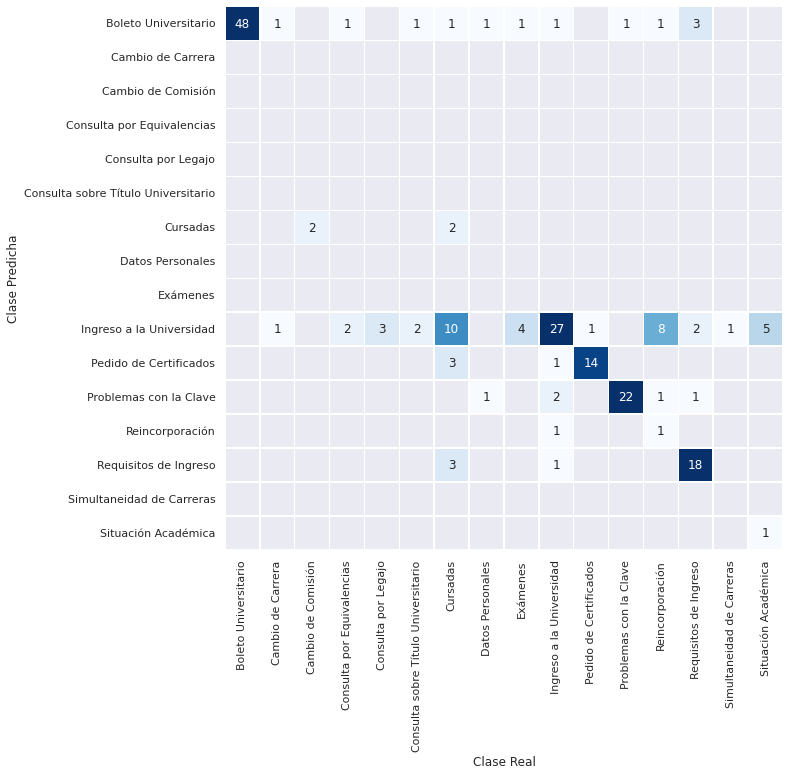

In [28]:
def matriz_confusion(y_real, y_predictions):
  """
  Grafica una matriz de confusión con seaborn en función de la clase observada
  y la clase predicha.
  """

  import numpy as np
  from sklearn import metrics
  import seaborn as sns
  import matplotlib.pyplot as plt
  
  matriz_confusion = metrics.confusion_matrix(y_real, y_predictions).T
  etiquetas = np.unique(y_real)

  sns.set()
  my_mask = np.zeros((matriz_confusion.shape[0], matriz_confusion.shape[0]), dtype=int)
  for i in range(matriz_confusion.shape[0]):
      for j in range(matriz_confusion.shape[0]):
          my_mask[i][j] = matriz_confusion[i][j] == 0 
    
  fig_dims = (10, 10)
  plt.subplots(figsize=fig_dims)

  ax = sns.heatmap(matriz_confusion,
                  xticklabels=etiquetas,
                  annot=True, 
                  fmt="d", 
                  linewidths=.5, 
                  cmap="Blues", 
                  cbar=False, 
                  mask=my_mask, 
                  vmax=15)

  plt.gcf().set_size_inches(10, 10)
  plt.xticks(rotation=90, ha="center")
  plt.yticks(np.arange(len(etiquetas))+0.5, etiquetas, rotation='horizontal')

  plt.xlabel('Clase Real')
  plt.ylabel('Clase Predicha');

  plt.show()

matriz_confusion(y_test, predictions)

# Referencias
- imbalanced-learn documentation https://imbalanced-learn.org/
- sklearn.model_selection.GridSearchCV https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- ML Pipelines using scikit-learn and GridSearchCV https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05